In [1]:
import gym
from gym import wrappers
import random
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

In [3]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        self.memory.append(transition)
        if len(self.memory) > self.capacity:
            del self.memory[0]

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
class Network(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(4, HIDDEN_LAYER)
        self.l2 = nn.Linear(HIDDEN_LAYER, 16)
        self.l3 = nn.Linear(16, 2)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x

In [5]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        return model(Variable(state, volatile=True).type(FloatTensor)).data.max(1)[1].view(1, 1)
    else:
        return LongTensor([[random.randrange(2)]])

In [6]:
def learn():
    if len(memory) < BATCH_SIZE:
        return

    # random transition batch is taken from experience replay memory
    transitions = memory.sample(BATCH_SIZE)
    batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

    batch_state = Variable(torch.cat(batch_state))
    batch_action = Variable(torch.cat(batch_action))
    batch_reward = Variable(torch.cat(batch_reward))
    batch_next_state = Variable(torch.cat(batch_next_state))

    # current Q values are estimated by NN for all actions
    current_q_values = model(batch_state).gather(1, batch_action)
    # expected Q values are estimated from actions which gives maximum Q value
    max_next_q_values = model(batch_next_state).detach().max(1)[0]
    expected_q_values = batch_reward + (GAMMA * max_next_q_values)

    # loss is measured from error between current and newly expected Q values
    loss = F.smooth_l1_loss(current_q_values, expected_q_values)

    # backpropagation of loss to NN
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [18]:
def run_episode(e, environment):
    state = environment.reset()
    steps = 0
    while True:
        steps += 1
        environment.render()
        action = select_action(FloatTensor([state]))
        next_state, reward, done, _ = environment.step(action.item())
        

        # zero reward when attempt ends
        if done and steps < 200:
            reward = 0

        memory.push((FloatTensor([state]),
                     action,  # action is already a tensor
                     FloatTensor([next_state]),
                     FloatTensor([reward])))
        print(state, action, next_state, reward)

        learn()
        print(state, action, next_state, reward)

        state = next_state

        if done:
            print("{2} Episode {0} finished after {1} steps"
                  .format(e, steps, '\033[92m' if steps >= 195 else '\033[99m'))
            episode_durations.append(steps)
            plot_durations()
            break

In [19]:
def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.FloatTensor(episode_durations)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated


# Hyperparameters

In [20]:
EPISODES = 600  # number of episodes
EPS_START = 0.9  # e-greedy threshold start value
EPS_END = 0.01  # e-greedy threshold end value
EPS_DECAY = 200  # e-greedy threshold decay
GAMMA = 0.80  # Q-learning discount factor
LR = 0.0005  # NN optimizer learning rate
HIDDEN_LAYER = 24  # NN hidden layer size
BATCH_SIZE = 128  # Q-learning batch size

# Load environment & network

In [21]:
env = gym.make('CartPole-v1')
# env = wrappers.Monitor(env, './tmp/cartpole-v0-1', force=True)

model = Network()
if use_cuda:
    model.cuda()
memory = ReplayMemory(10000)
optimizer = optim.Adam(model.parameters(), LR)
steps_done = 0
episode_durations = []

[-0.03186715 -0.00221795 -0.0069061  -0.01262126] tensor([[0]], device='cuda:0') [-0.03191151 -0.19724018 -0.00715853  0.27787473] 1.0
[-0.03186715 -0.00221795 -0.0069061  -0.01262126] tensor([[0]], device='cuda:0') [-0.03191151 -0.19724018 -0.00715853  0.27787473] 1.0
[-0.03191151 -0.19724018 -0.00715853  0.27787473] tensor([[1]], device='cuda:0') [-0.03585632 -0.00201684 -0.00160104 -0.01705737] 1.0
[-0.03191151 -0.19724018 -0.00715853  0.27787473] tensor([[1]], device='cuda:0') [-0.03585632 -0.00201684 -0.00160104 -0.01705737] 1.0
[-0.03585632 -0.00201684 -0.00160104 -0.01705737] tensor([[0]], device='cuda:0') [-0.03589665 -0.19711579 -0.00194218  0.27511998] 1.0
[-0.03585632 -0.00201684 -0.00160104 -0.01705737] tensor([[0]], device='cuda:0') [-0.03589665 -0.19711579 -0.00194218  0.27511998] 1.0
[-0.03589665 -0.19711579 -0.00194218  0.27511998] 

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


tensor([[0]], device='cuda:0') [-0.03983897 -0.39220998  0.00356022  0.56718971] 1.0
[-0.03589665 -0.19711579 -0.00194218  0.27511998] tensor([[0]], device='cuda:0') [-0.03983897 -0.39220998  0.00356022  0.56718971] 1.0
[-0.03983897 -0.39220998  0.00356022  0.56718971] tensor([[0]], device='cuda:0') [-0.04768317 -0.58738169  0.01490401  0.86099212] 1.0
[-0.03983897 -0.39220998  0.00356022  0.56718971] tensor([[0]], device='cuda:0') [-0.04768317 -0.58738169  0.01490401  0.86099212] 1.0
[-0.04768317 -0.58738169  0.01490401  0.86099212] tensor([[0]], device='cuda:0') [-0.0594308  -0.7827034   0.03212385  1.15832377] 1.0
[-0.04768317 -0.58738169  0.01490401  0.86099212] tensor([[0]], device='cuda:0') [-0.0594308  -0.7827034   0.03212385  1.15832377] 1.0
[-0.0594308  -0.7827034   0.03212385  1.15832377] tensor([[1]], device='cuda:0') [-0.07508487 -0.58801449  0.05529033  0.87588386] 1.0
[-0.0594308  -0.7827034   0.03212385  1.15832377] tensor([[1]], device='cuda:0') [-0.07508487 -0.58801449

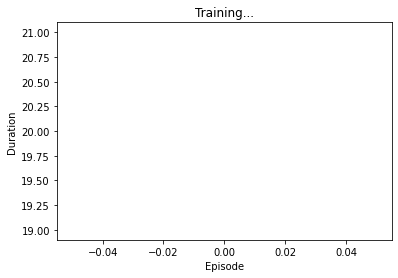

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


[0.00567466 0.04436264 0.03659206 0.03970459] tensor([[0]], device='cuda:0') [ 0.00656191 -0.15126441  0.03738615  0.3437044 ] 1.0
[0.00567466 0.04436264 0.03659206 0.03970459] tensor([[0]], device='cuda:0') [ 0.00656191 -0.15126441  0.03738615  0.3437044 ] 1.0
[ 0.00656191 -0.15126441  0.03738615  0.3437044 ] tensor([[1]], device='cuda:0') [0.00353663 0.04330628 0.04426024 0.06304127] 1.0
[ 0.00656191 -0.15126441  0.03738615  0.3437044 ] tensor([[1]], device='cuda:0') [0.00353663 0.04330628 0.04426024 0.06304127] 1.0
[0.00353663 0.04330628 0.04426024 0.06304127] tensor([[0]], device='cuda:0') [ 0.00440275 -0.15242139  0.04552106  0.36935351] 1.0
[0.00353663 0.04330628 0.04426024 0.06304127] tensor([[0]], device='cuda:0') [ 0.00440275 -0.15242139  0.04552106  0.36935351] 1.0
[ 0.00440275 -0.15242139  0.04552106  0.36935351] tensor([[0]], device='cuda:0') [ 0.00135432 -0.34815956  0.05290813  0.67603519] 1.0
[ 0.00440275 -0.15242139  0.04552106  0.36935351] tensor([[0]], device='cuda:0'

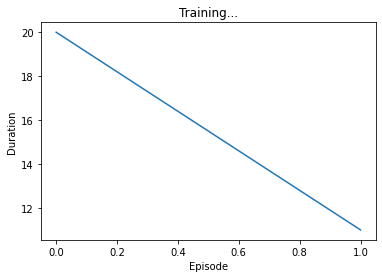

[-0.00021469 -0.0160328   0.00803685  0.04965882] tensor([[0]], device='cuda:0') [-0.00053535 -0.21126907  0.00903003  0.34486657] 1.0
[-0.00021469 -0.0160328   0.00803685  0.04965882] tensor([[0]], device='cuda:0') [-0.00053535 -0.21126907  0.00903003  0.34486657] 1.0
[-0.00053535 -0.21126907  0.00903003  0.34486657] tensor([[0]], device='cuda:0') [-0.00476073 -0.4065183   0.01592736  0.64038328] 1.0
[-0.00053535 -0.21126907  0.00903003  0.34486657] tensor([[0]], device='cuda:0') [-0.00476073 -0.4065183   0.01592736  0.64038328] 1.0
[-0.00476073 -0.4065183   0.01592736  0.64038328] tensor([[0]], device='cuda:0') [-0.0128911  -0.60185864  0.02873502  0.93803906] 1.0
[-0.00476073 -0.4065183   0.01592736  0.64038328] tensor([[0]], device='cuda:0') [-0.0128911  -0.60185864  0.02873502  0.93803906] 1.0
[-0.0128911  -0.60185864  0.02873502  0.93803906] tensor([[1]], device='cuda:0') [-0.02492827 -0.40713566  0.04749581  0.65452211] 1.0
[-0.0128911  -0.60185864  0.02873502  0.93803906] tenso

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


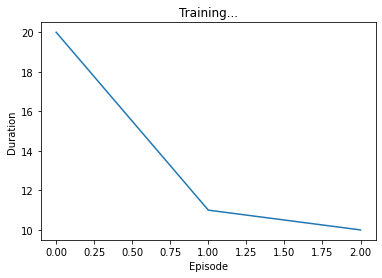

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


[ 0.0295343  -0.03699277  0.04871331  0.04058756] tensor([[0]], device='cuda:0') [ 0.02879444 -0.23277819  0.04952506  0.34823336] 1.0
[ 0.0295343  -0.03699277  0.04871331  0.04058756] tensor([[0]], device='cuda:0') [ 0.02879444 -0.23277819  0.04952506  0.34823336] 1.0
[ 0.02879444 -0.23277819  0.04952506  0.34823336] tensor([[0]], device='cuda:0') [ 0.02413888 -0.42856828  0.05648973  0.65611281] 1.0
[ 0.02879444 -0.23277819  0.04952506  0.34823336] tensor([[0]], device='cuda:0') [ 0.02413888 -0.42856828  0.05648973  0.65611281] 1.0
[ 0.02413888 -0.42856828  0.05648973  0.65611281] tensor([[0]], device='cuda:0') [ 0.01556751 -0.62442926  0.06961199  0.9660348 ] 1.0
[ 0.02413888 -0.42856828  0.05648973  0.65611281] tensor([[0]], device='cuda:0') [ 0.01556751 -0.62442926  0.06961199  0.9660348 ] 1.0
[ 0.01556751 -0.62442926  0.06961199  0.9660348 ] tensor([[0]], device='cuda:0') [ 0.00307893 -0.82041362  0.08893268  1.27974874] 1.0
[ 0.01556751 -0.62442926  0.06961199  0.9660348 ] tenso

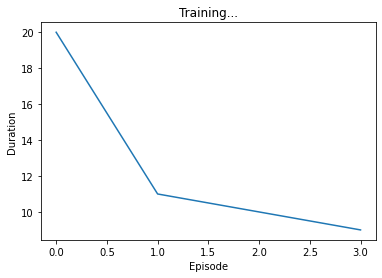

[-0.00583684 -0.00176107  0.0299241   0.0195337 ] tensor([[0]], device='cuda:0') [-0.00587206 -0.19729911  0.03031477  0.32150581] 1.0
[-0.00583684 -0.00176107  0.0299241   0.0195337 ] tensor([[0]], device='cuda:0') [-0.00587206 -0.19729911  0.03031477  0.32150581] 1.0
[-0.00587206 -0.19729911  0.03031477  0.32150581] tensor([[0]], device='cuda:0') [-0.00981804 -0.39283935  0.03674489  0.62359259] 1.0
[-0.00587206 -0.19729911  0.03031477  0.32150581] tensor([[0]], device='cuda:0') [-0.00981804 -0.39283935  0.03674489  0.62359259] 1.0
[-0.00981804 -0.39283935  0.03674489  0.62359259] tensor([[1]], device='cuda:0') [-0.01767483 -0.19824918  0.04921674  0.34270492] 1.0
[-0.00981804 -0.39283935  0.03674489  0.62359259] tensor([[1]], device='cuda:0') [-0.01767483 -0.19824918  0.04921674  0.34270492] 1.0
[-0.01767483 -0.19824918  0.04921674  0.34270492] tensor([[0]], device='cuda:0') [-0.02163981 -0.39403552  0.05607084  0.6504927 ] 1.0
[-0.01767483 -0.19824918  0.04921674  0.34270492] tenso

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


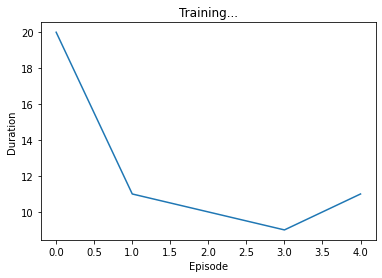

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


[ 0.01350035 -0.04493564 -0.02898877 -0.03666029] tensor([[0]], device='cuda:0') [ 0.01260164 -0.23963015 -0.02972198  0.24673728] 1.0
[ 0.01350035 -0.04493564 -0.02898877 -0.03666029] tensor([[0]], device='cuda:0') [ 0.01260164 -0.23963015 -0.02972198  0.24673728] 1.0
[ 0.01260164 -0.23963015 -0.02972198  0.24673728] tensor([[0]], device='cuda:0') [ 0.00780903 -0.43431528 -0.02478723  0.52989902] 1.0
[ 0.01260164 -0.23963015 -0.02972198  0.24673728] tensor([[0]], device='cuda:0') [ 0.00780903 -0.43431528 -0.02478723  0.52989902] 1.0
[ 0.00780903 -0.43431528 -0.02478723  0.52989902] tensor([[0]], device='cuda:0') [-0.00087727 -0.62907993 -0.01418925  0.81466955] 1.0
[ 0.00780903 -0.43431528 -0.02478723  0.52989902] tensor([[0]], device='cuda:0') [-0.00087727 -0.62907993 -0.01418925  0.81466955] 1.0
[-0.00087727 -0.62907993 -0.01418925  0.81466955] tensor([[1]], device='cuda:0') [-0.01345887 -0.43376658  0.00210414  0.51755751] 1.0
[-0.00087727 -0.62907993 -0.01418925  0.81466955] tenso

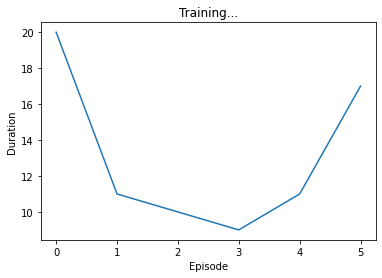

[4.29411231e-05 3.74068058e-02 6.19978291e-03 1.11431080e-03] tensor([[1]], device='cuda:0') [ 0.00079108  0.2324393   0.00622207 -0.28960608] 1.0
[4.29411231e-05 3.74068058e-02 6.19978291e-03 1.11431080e-03] tensor([[1]], device='cuda:0') [ 0.00079108  0.2324393   0.00622207 -0.28960608] 1.0
[ 0.00079108  0.2324393   0.00622207 -0.28960608] tensor([[1]], device='cuda:0') [ 5.43986318e-03  4.27471973e-01  4.29947552e-04 -5.80320154e-01] 1.0
[ 0.00079108  0.2324393   0.00622207 -0.28960608] tensor([[1]], device='cuda:0') [ 5.43986318e-03  4.27471973e-01  4.29947552e-04 -5.80320154e-01] 1.0
[ 5.43986318e-03  4.27471973e-01  4.29947552e-04 -5.80320154e-01] tensor([[0]], device='cuda:0') [ 0.0139893   0.232344   -0.01117646 -0.28750182] 1.0
[ 5.43986318e-03  4.27471973e-01  4.29947552e-04 -5.80320154e-01] tensor([[0]], device='cuda:0') [ 0.0139893   0.232344   -0.01117646 -0.28750182] 1.0
[ 0.0139893   0.232344   -0.01117646 -0.28750182] tensor([[0]], device='cuda:0') [ 0.01863618  0.03738

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


tensor([[0]], device='cuda:0') [ 0.0012933  -0.35236719  0.01646458  0.57614832] 1.0
[ 0.00443514 -0.15709197  0.0108634   0.28005899] tensor([[0]], device='cuda:0') [ 0.0012933  -0.35236719  0.01646458  0.57614832] 1.0
[ 0.0012933  -0.35236719  0.01646458  0.57614832] tensor([[0]], device='cuda:0') [-0.00575404 -0.54771602  0.02798755  0.87397221] 1.0
[ 0.0012933  -0.35236719  0.01646458  0.57614832] tensor([[0]], device='cuda:0') [-0.00575404 -0.54771602  0.02798755  0.87397221] 1.0
[-0.00575404 -0.54771602  0.02798755  0.87397221] tensor([[0]], device='cuda:0') [-0.01670836 -0.74320709  0.04546699  1.17532124] 1.0
[-0.00575404 -0.54771602  0.02798755  0.87397221] tensor([[0]], device='cuda:0') [-0.01670836 -0.74320709  0.04546699  1.17532124] 1.0
[-0.01670836 -0.74320709  0.04546699  1.17532124] tensor([[0]], device='cuda:0') [-0.03157251 -0.93888937  0.06897342  1.48190402] 1.0
[-0.01670836 -0.74320709  0.04546699  1.17532124] tensor([[0]], device='cuda:0') [-0.03157251 -0.93888937

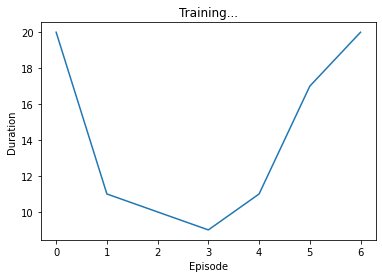

[ 0.03831674  0.02380275 -0.0269951   0.04286684] tensor([[1]], device='cuda:0') [ 0.03879279  0.21930119 -0.02613777 -0.25820957] 1.0
[ 0.03831674  0.02380275 -0.0269951   0.04286684] tensor([[1]], device='cuda:0') [ 0.03879279  0.21930119 -0.02613777 -0.25820957] 1.0
[ 0.03879279  0.21930119 -0.02613777 -0.25820957] tensor([[0]], device='cuda:0') [ 0.04317881  0.02456196 -0.03130196  0.02611588] 1.0
[ 0.03879279  0.21930119 -0.02613777 -0.25820957] tensor([[0]], device='cuda:0') [ 0.04317881  0.02456196 -0.03130196  0.02611588] 1.0
[ 0.04317881  0.02456196 -0.03130196  0.02611588] tensor([[0]], device='cuda:0') [ 0.04367005 -0.17009744 -0.03077964  0.30876067] 1.0
[ 0.04317881  0.02456196 -0.03130196  0.02611588] tensor([[0]], device='cuda:0') [ 0.04367005 -0.17009744 -0.03077964  0.30876067] 1.0
[ 0.04367005 -0.17009744 -0.03077964  0.30876067] tensor([[0]], device='cuda:0') [ 0.0402681  -0.36476762 -0.02460443  0.59157984] 1.0
[ 0.04367005 -0.17009744 -0.03077964  0.30876067] tenso

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


tensor([[0]], device='cuda:0') [-0.07280255 -1.14929968  0.15393932  1.8685262 ] 1.0
[-0.05374393 -0.95293055  0.12313748  1.54009182] tensor([[0]], device='cuda:0') [-0.07280255 -1.14929968  0.15393932  1.8685262 ] 1.0
[-0.07280255 -1.14929968  0.15393932  1.8685262 ] tensor([[0]], device='cuda:0') [-0.09578854 -1.34573443  0.19130984  2.20477359] 1.0
[-0.07280255 -1.14929968  0.15393932  1.8685262 ] tensor([[0]], device='cuda:0') [-0.09578854 -1.34573443  0.19130984  2.20477359] 1.0
[-0.09578854 -1.34573443  0.19130984  2.20477359] tensor([[0]], device='cuda:0') [-0.12270323 -1.54211231  0.23540531  2.54986898] 0
[-0.09578854 -1.34573443  0.19130984  2.20477359] tensor([[0]], device='cuda:0') [-0.12270323 -1.54211231  0.23540531  2.54986898] 0
 Episode 7 finished after 14 steps


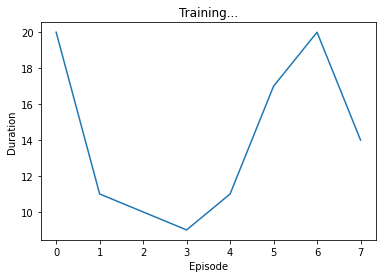

[-0.01143103 -0.03955265  0.03933031  0.01545108] tensor([[0]], device='cuda:0') [-0.01222208 -0.23521593  0.03963933  0.32027916] 1.0
[-0.01143103 -0.03955265  0.03933031  0.01545108] tensor([[0]], device='cuda:0') [-0.01222208 -0.23521593  0.03963933  0.32027916] 1.0
[-0.01222208 -0.23521593  0.03963933  0.32027916] tensor([[0]], device='cuda:0') [-0.0169264  -0.43087932  0.04604491  0.62519461] 1.0
[-0.01222208 -0.23521593  0.03963933  0.32027916] tensor([[0]], device='cuda:0') [-0.0169264  -0.43087932  0.04604491  0.62519461] 1.0
[-0.0169264  -0.43087932  0.04604491  0.62519461] tensor([[1]], device='cuda:0') [-0.02554399 -0.23642938  0.0585488   0.34736126] 1.0
[-0.0169264  -0.43087932  0.04604491  0.62519461] tensor([[1]], device='cuda:0') [-0.02554399 -0.23642938  0.0585488   0.34736126] 1.0
[-0.02554399 -0.23642938  0.0585488   0.34736126] 

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


tensor([[0]], device='cuda:0') [-0.03027257 -0.43233312  0.06549603  0.65791686] 1.0
[-0.02554399 -0.23642938  0.0585488   0.34736126] tensor([[0]], device='cuda:0') [-0.03027257 -0.43233312  0.06549603  0.65791686] 1.0
[-0.03027257 -0.43233312  0.06549603  0.65791686] tensor([[0]], device='cuda:0') [-0.03891924 -0.62830263  0.07865437  0.97048293] 1.0
[-0.03027257 -0.43233312  0.06549603  0.65791686] tensor([[0]], device='cuda:0') [-0.03891924 -0.62830263  0.07865437  0.97048293] 1.0
[-0.03891924 -0.62830263  0.07865437  0.97048293] tensor([[0]], device='cuda:0') [-0.05148529 -0.82438718  0.09806402  1.28680096] 1.0
[-0.03891924 -0.62830263  0.07865437  0.97048293] tensor([[0]], device='cuda:0') [-0.05148529 -0.82438718  0.09806402  1.28680096] 1.0
[-0.05148529 -0.82438718  0.09806402  1.28680096] tensor([[0]], device='cuda:0') [-0.06797303 -1.02061071  0.12380004  1.60850679] 1.0
[-0.05148529 -0.82438718  0.09806402  1.28680096] tensor([[0]], device='cuda:0') [-0.06797303 -1.02061071

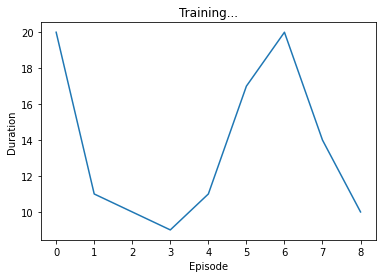

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


[ 0.02417175  0.04094427 -0.0375584  -0.0055841 ] tensor([[0]], device='cuda:0') [ 0.02499064 -0.15361947 -0.03767008  0.27501612] 1.0
[ 0.02417175  0.04094427 -0.0375584  -0.0055841 ] tensor([[0]], device='cuda:0') [ 0.02499064 -0.15361947 -0.03767008  0.27501612] 1.0
[ 0.02499064 -0.15361947 -0.03767008  0.27501612] tensor([[0]], device='cuda:0') [ 0.02191825 -0.34818428 -0.03216976  0.5555839 ] 1.0
[ 0.02499064 -0.15361947 -0.03767008  0.27501612] tensor([[0]], device='cuda:0') [ 0.02191825 -0.34818428 -0.03216976  0.5555839 ] 1.0
[ 0.02191825 -0.34818428 -0.03216976  0.5555839 ] tensor([[0]], device='cuda:0') [ 0.01495457 -0.54284014 -0.02105808  0.83796034] 1.0
[ 0.02191825 -0.34818428 -0.03216976  0.5555839 ] tensor([[0]], device='cuda:0') [ 0.01495457 -0.54284014 -0.02105808  0.83796034] 1.0
[ 0.01495457 -0.54284014 -0.02105808  0.83796034] tensor([[1]], device='cuda:0') [ 0.00409776 -0.34743703 -0.00429888  0.53873005] 1.0
[ 0.01495457 -0.54284014 -0.02105808  0.83796034] tenso

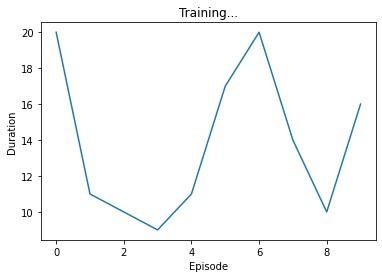

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


[-0.02365508  0.02850567  0.01748245  0.02372965] tensor([[0]], device='cuda:0') [-0.02308496 -0.16686257  0.01795704  0.32187682] 1.0
[-0.02365508  0.02850567  0.01748245  0.02372965] tensor([[0]], device='cuda:0') [-0.02308496 -0.16686257  0.01795704  0.32187682] 1.0
[-0.02308496 -0.16686257  0.01795704  0.32187682] tensor([[1]], device='cuda:0') [-0.02642221  0.02799912  0.02439457  0.03491049] 1.0
[-0.02308496 -0.16686257  0.01795704  0.32187682] tensor([[1]], device='cuda:0') [-0.02642221  0.02799912  0.02439457  0.03491049] 1.0
[-0.02642221  0.02799912  0.02439457  0.03491049] tensor([[1]], device='cuda:0') [-0.02586223  0.22276291  0.02509278 -0.24997698] 1.0
[-0.02642221  0.02799912  0.02439457  0.03491049] tensor([[1]], device='cuda:0') [-0.02586223  0.22276291  0.02509278 -0.24997698] 1.0
[-0.02586223  0.22276291  0.02509278 -0.24997698] tensor([[0]], device='cuda:0') [-0.02140697  0.02729177  0.02009324  0.05051393] 1.0
[-0.02586223  0.22276291  0.02509278 -0.24997698] tenso

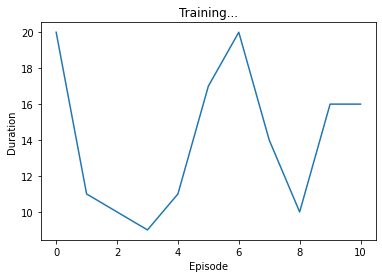

[ 0.00611879 -0.01392427  0.0230258  -0.00138325] tensor([[0]], device='cuda:0') [ 0.00584031 -0.20936875  0.02299813  0.29847474] 1.0
[ 0.00611879 -0.01392427  0.0230258  -0.00138325] tensor([[0]], device='cuda:0') [ 0.00584031 -0.20936875  0.02299813  0.29847474] 1.0
[ 0.00584031 -0.20936875  0.02299813  0.29847474] 

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


tensor([[0]], device='cuda:0') [ 0.00165293 -0.40481085  0.02896763  0.59832122] 1.0
[ 0.00584031 -0.20936875  0.02299813  0.29847474] tensor([[0]], device='cuda:0') [ 0.00165293 -0.40481085  0.02896763  0.59832122] 1.0
[ 0.00165293 -0.40481085  0.02896763  0.59832122] tensor([[0]], device='cuda:0') [-0.00644329 -0.60032589  0.04093405  0.89998604] 1.0
[ 0.00165293 -0.40481085  0.02896763  0.59832122] tensor([[0]], device='cuda:0') [-0.00644329 -0.60032589  0.04093405  0.89998604] 1.0
[-0.00644329 -0.60032589  0.04093405  0.89998604] tensor([[0]], device='cuda:0') [-0.0184498  -0.79597792  0.05893377  1.2052495 ] 1.0
[-0.00644329 -0.60032589  0.04093405  0.89998604] tensor([[0]], device='cuda:0') [-0.0184498  -0.79597792  0.05893377  1.2052495 ] 1.0
[-0.0184498  -0.79597792  0.05893377  1.2052495 ] tensor([[0]], device='cuda:0') [-0.03436936 -0.99180993  0.08303876  1.51580404] 1.0
[-0.0184498  -0.79597792  0.05893377  1.2052495 ] tensor([[0]], device='cuda:0') [-0.03436936 -0.99180993

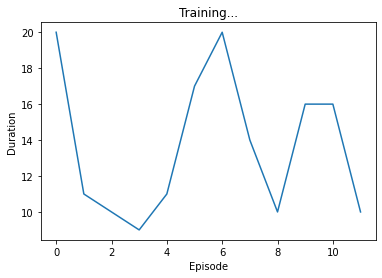

[ 0.00637271 -0.00810989  0.00934642  0.03747941] tensor([[0]], device='cuda:0') [ 0.00621051 -0.20336461  0.010096    0.33309651] 1.0
[ 0.00637271 -0.00810989  0.00934642  0.03747941] tensor([[0]], device='cuda:0') [ 0.00621051 -0.20336461  0.010096    0.33309651] 1.0
[ 0.00621051 -0.20336461  0.010096    0.33309651] tensor([[0]], device='cuda:0') [ 0.00214322 -0.39862879  0.01675793  0.62894603] 1.0
[ 0.00621051 -0.20336461  0.010096    0.33309651] tensor([[0]], device='cuda:0') [ 0.00214322 -0.39862879  0.01675793  0.62894603] 1.0
[ 0.00214322 -0.39862879  0.01675793  0.62894603] tensor([[1]], device='cuda:0') [-0.00582935 -0.20374467  0.02933686  0.34158749] 1.0
[ 0.00214322 -0.39862879  0.01675793  0.62894603] tensor([[1]], device='cuda:0') [-0.00582935 -0.20374467  0.02933686  0.34158749] 1.0
[-0.00582935 -0.20374467  0.02933686  0.34158749] tensor([[0]], device='cuda:0') [-0.00990425 -0.39927146  0.03616861  0.64337528] 1.0
[-0.00582935 -0.20374467  0.02933686  0.34158749] tenso

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


tensor([[0]], device='cuda:0') [-0.08898373 -1.37888597  0.16220599  2.21685368] 1.0
[-0.06533072 -1.18265071  0.12444027  1.88828583] tensor([[0]], device='cuda:0') [-0.08898373 -1.37888597  0.16220599  2.21685368] 1.0
[-0.08898373 -1.37888597  0.16220599  2.21685368] tensor([[0]], device='cuda:0') [-0.11656145 -1.57514477  0.20654306  2.55485729] 1.0
[-0.08898373 -1.37888597  0.16220599  2.21685368] tensor([[0]], device='cuda:0') [-0.11656145 -1.57514477  0.20654306  2.55485729] 1.0
[-0.11656145 -1.57514477  0.20654306  2.55485729] tensor([[1]], device='cuda:0') [-0.14806435 -1.38218926  0.25764021  2.33186855] 0
[-0.11656145 -1.57514477  0.20654306  2.55485729] tensor([[1]], device='cuda:0') [-0.14806435 -1.38218926  0.25764021  2.33186855] 0
 Episode 12 finished after 11 steps


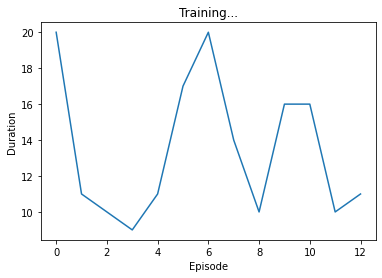

[-0.00148622  0.04139006 -0.04771051 -0.01601213] tensor([[0]], device='cuda:0') [-0.00065842 -0.15301634 -0.04803076  0.26124408] 1.0
[-0.00148622  0.04139006 -0.04771051 -0.01601213] tensor([[0]], device='cuda:0') [-0.00065842 -0.15301634 -0.04803076  0.26124408] 1.0
[-0.00065842 -0.15301634 -0.04803076  0.26124408] tensor([[0]], device='cuda:0') [-0.00371875 -0.34742093 -0.04280587  0.53839905] 1.0
[-0.00065842 -0.15301634 -0.04803076  0.26124408] tensor([[0]], device='cuda:0') [-0.00371875 -0.34742093 -0.04280587  0.53839905] 1.0
[-0.00371875 -0.34742093 -0.04280587  0.53839905] 

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


tensor([[0]], device='cuda:0') [-0.01066717 -0.54191577 -0.03203789  0.81729299] 1.0
[-0.00371875 -0.34742093 -0.04280587  0.53839905] tensor([[0]], device='cuda:0') [-0.01066717 -0.54191577 -0.03203789  0.81729299] 1.0
[-0.01066717 -0.54191577 -0.03203789  0.81729299] tensor([[1]], device='cuda:0') [-0.02150548 -0.34637022 -0.01569203  0.51470765] 1.0
[-0.01066717 -0.54191577 -0.03203789  0.81729299] tensor([[1]], device='cuda:0') [-0.02150548 -0.34637022 -0.01569203  0.51470765] 1.0
[-0.02150548 -0.34637022 -0.01569203  0.51470765] tensor([[0]], device='cuda:0') [-0.02843289 -0.54126771 -0.00539788  0.80240462] 1.0
[-0.02150548 -0.34637022 -0.01569203  0.51470765] tensor([[0]], device='cuda:0') [-0.02843289 -0.54126771 -0.00539788  0.80240462] 1.0
[-0.02843289 -0.54126771 -0.00539788  0.80240462] tensor([[0]], device='cuda:0') [-0.03925824 -0.73631522  0.01065021  1.09338466] 1.0
[-0.02843289 -0.54126771 -0.00539788  0.80240462] tensor([[0]], device='cuda:0') [-0.03925824 -0.73631522

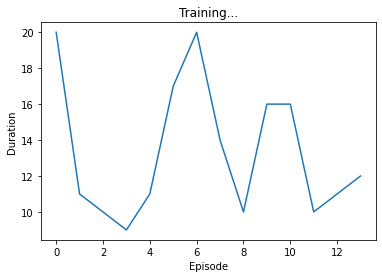

[ 0.01084512  0.01727158 -0.01703811  0.03145195] tensor([[0]], device='cuda:0') [ 0.01119055 -0.17760194 -0.01640907  0.31871085] 1.0
[ 0.01084512  0.01727158 -0.01703811  0.03145195] tensor([[0]], device='cuda:0') [ 0.01119055 -0.17760194 -0.01640907  0.31871085] 1.0
[ 0.01119055 -0.17760194 -0.01640907  0.31871085] tensor([[1]], device='cuda:0') [ 0.00763851  0.01774982 -0.01003486  0.0208986 ] 1.0
[ 0.01119055 -0.17760194 -0.01640907  0.31871085] tensor([[1]], device='cuda:0') [ 0.00763851  0.01774982 -0.01003486  0.0208986 ] 1.0
[ 0.00763851  0.01774982 -0.01003486  0.0208986 ] tensor([[0]], device='cuda:0') [ 0.00799351 -0.17722679 -0.00961688  0.3103986 ] 1.0
[ 0.00763851  0.01774982 -0.01003486  0.0208986 ] tensor([[0]], device='cuda:0') [ 0.00799351 -0.17722679 -0.00961688  0.3103986 ] 1.0
[ 0.00799351 -0.17722679 -0.00961688  0.3103986 ] tensor([[1]], device='cuda:0') [ 0.00444897  0.01803085 -0.00340891  0.01469836] 1.0
[ 0.00799351 -0.17722679 -0.00961688  0.3103986 ] tenso

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


tensor([[0]], device='cuda:0') [ 0.00907362  0.01812414 -0.00869611  0.01264069] 1.0
[ 0.00480959  0.21320152 -0.00311494 -0.27905816] tensor([[0]], device='cuda:0') [ 0.00907362  0.01812414 -0.00869611  0.01264069] 1.0
[ 0.00907362  0.01812414 -0.00869611  0.01264069] tensor([[0]], device='cuda:0') [ 0.0094361  -0.17687202 -0.00844329  0.30256725] 1.0
[ 0.00907362  0.01812414 -0.00869611  0.01264069] tensor([[0]], device='cuda:0') [ 0.0094361  -0.17687202 -0.00844329  0.30256725] 1.0
[ 0.0094361  -0.17687202 -0.00844329  0.30256725] tensor([[0]], device='cuda:0') [ 0.00589866 -0.37187263 -0.00239195  0.59257544] 1.0
[ 0.0094361  -0.17687202 -0.00844329  0.30256725] tensor([[0]], device='cuda:0') [ 0.00589866 -0.37187263 -0.00239195  0.59257544] 1.0
[ 0.00589866 -0.37187263 -0.00239195  0.59257544] tensor([[0]], device='cuda:0') [-0.00153879 -0.56696101  0.00945956  0.88450394] 1.0
[ 0.00589866 -0.37187263 -0.00239195  0.59257544] tensor([[0]], device='cuda:0') [-0.00153879 -0.56696101

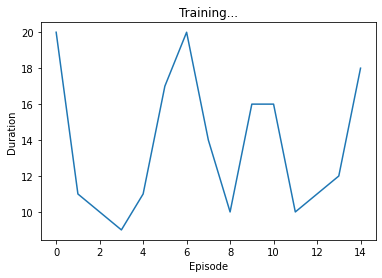

[ 0.01075721 -0.02166568 -0.04147625  0.02662305] tensor([[1]], device='cuda:0') [ 0.01032389  0.17402577 -0.04094379 -0.2788522 ] 1.0
[ 0.01075721 -0.02166568 -0.04147625  0.02662305] tensor([[1]], device='cuda:0') [ 0.01032389  0.17402577 -0.04094379 -0.2788522 ] 1.0
[ 0.01032389  0.17402577 -0.04094379 -0.2788522 ] tensor([[0]], device='cuda:0') [ 0.01380441 -0.0204889  -0.04652083  0.00064117] 1.0
[ 0.01032389  0.17402577 -0.04094379 -0.2788522 ] tensor([[0]], device='cuda:0') [ 0.01380441 -0.0204889  -0.04652083  0.00064117] 1.0
[ 0.01380441 -0.0204889  -0.04652083  0.00064117] tensor([[0]], device='cuda:0') [ 0.01339463 -0.21491387 -0.04650801  0.27829091] 1.0
[ 0.01380441 -0.0204889  -0.04652083  0.00064117] tensor([[0]], device='cuda:0') [ 0.01339463 -0.21491387 -0.04650801  0.27829091] 1.0
[ 0.01339463 -0.21491387 -0.04650801  0.27829091] tensor([[0]], device='cuda:0') [ 0.00909635 -0.40934256 -0.04094219  0.55595016] 1.0
[ 0.01339463 -0.21491387 -0.04650801  0.27829091] tenso

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


tensor([[0]], device='cuda:0') [-0.12655915 -1.58163902  0.15172838  2.36565482] 1.0
[-0.09884785 -1.38556495  0.11091219  2.04080951] tensor([[0]], device='cuda:0') [-0.12655915 -1.58163902  0.15172838  2.36565482] 1.0
[-0.12655915 -1.58163902  0.15172838  2.36565482] tensor([[0]], device='cuda:0') [-0.15819193 -1.77775068  0.19904147  2.70087989] 1.0
[-0.12655915 -1.58163902  0.15172838  2.36565482] tensor([[0]], device='cuda:0') [-0.15819193 -1.77775068  0.19904147  2.70087989] 1.0
[-0.15819193 -1.77775068  0.19904147  2.70087989] tensor([[0]], device='cuda:0') [-0.19374694 -1.97368464  0.25305907  3.0471108 ] 0
[-0.15819193 -1.77775068  0.19904147  2.70087989] tensor([[0]], device='cuda:0') [-0.19374694 -1.97368464  0.25305907  3.0471108 ] 0
 Episode 15 finished after 14 steps


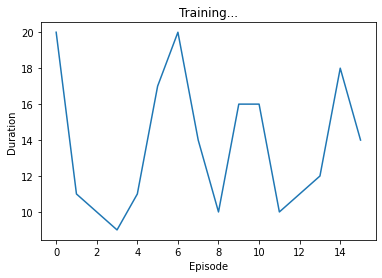

[ 0.04337089 -0.04668039  0.03137002  0.00425345] tensor([[0]], device='cuda:0') [ 0.04243728 -0.24223786  0.03145509  0.3066666 ] 1.0
[ 0.04337089 -0.04668039  0.03137002  0.00425345] tensor([[0]], device='cuda:0') [ 0.04243728 -0.24223786  0.03145509  0.3066666 ] 1.0
[ 0.04243728 -0.24223786  0.03145509  0.3066666 ] tensor([[0]], device='cuda:0') [ 0.03759252 -0.43779359  0.03758842  0.60910136] 1.0
[ 0.04243728 -0.24223786  0.03145509  0.3066666 ] tensor([[0]], device='cuda:0') [ 0.03759252 -0.43779359  0.03758842  0.60910136] 1.0
[ 0.03759252 -0.43779359  0.03758842  0.60910136] tensor([[0]], device='cuda:0') [ 0.02883665 -0.63342028  0.04977044  0.91338253] 1.0
[ 0.03759252 -0.43779359  0.03758842  0.60910136]

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


KeyboardInterrupt: 

In [22]:
for e in range(EPISODES):

    run_episode(e, env)

print('Complete')
env.render(close=True)
env.close()
plt.ioff()
plt.show()